# Predicting field goals made from NBA shot logs

## 1 Imports

We will state our imports, as usual. You will find that we are using the `preprocessing` module of `sklearn`, in addition to `pandas` and `numpy`.

In [1]:
import pandas as pd 
import numpy  as np

% matplotlib inline
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp

## 2 Read data

Let's start by loading the data. For convenience, we will make all column names upper case, so we don't have to consider that throughout the analysis.

In [2]:
def read_data(path, with_preview=False):
    
    data = pd.read_csv(path)
    data.columns = data.columns.str.upper()
    
    return data


data = read_data("../data/shot_logs.csv")

## 3 Extracting features from the `MATCHUP` column

As in many real world problems, we have a column holding information about more than one feature.

So we can use them throughout the example and the practice exercise we need to extract all the feature to separate columns.

In [3]:
def extract_features(string):
    
    (date, string) = string.split('-')
    
    if '@' in string:
        (away, home) = string.split('@')
    if 'vs.' in string:
        (away, home) = string.split('vs.')
   
    date = date.strip()
    away = away.strip()
    home = home.strip()
    
    return (date, away, home)
    
    
def extract_date(string):
    
    features = extract_features(string)
    
    date = features[0]
    date = pd.to_datetime(date)
    date = date
    
    return date


def extract_away_team(string):
    
    features = extract_features(string)
    away = features[1]
    
    return away


def extract_home_team(string):
    
    features = extract_features(string)
    home = features[2]
    
    return home
    
    
def expand_matchup_column(data, with_preview=False):
    
    data['MATCHUP_DATE']      = data['MATCHUP'].apply(extract_date)
    data['MATCHUP_DATE']      = data['MATCHUP_DATE'].astype(np.int64) / int(1e6)
    data['MATCHUP_AWAY_TEAM'] = data['MATCHUP'].apply(extract_away_team)
    data['MATCHUP_HOME_TEAM'] = data['MATCHUP'].apply(extract_home_team)
    
    data = data.drop('MATCHUP', axis=1)
    
    return data


data = expand_matchup_column(data)

## 3 Dealing categorical features

As you can see below, there are plenty of categorical features in our dataset.

We will grab one of them, the `MATCHUP_AWAY_TEAM`, and perform different types of encoding on it, so you can get a sense of what they do.

In [4]:
display(data.head(n=3))
data.columns.values

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,MATCHUP_DATE,MATCHUP_AWAY_TEAM,MATCHUP_HOME_TEAM
0,21400899,A,W,24,1,1,1:09,10.8,2,1.9,...,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,1.425427e+12,CHA,BKN
1,21400899,A,W,24,2,1,0:14,3.4,0,0.8,...,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,1.425427e+12,CHA,BKN
2,21400899,A,W,24,3,1,0:00,NaN,3,2.7,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,1.425427e+12,CHA,BKN


array(['GAME_ID', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD',
       'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST',
       'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'PLAYER_NAME', 'PLAYER_ID', 'MATCHUP_DATE', 'MATCHUP_AWAY_TEAM',
       'MATCHUP_HOME_TEAM'], dtype=object)

### 3.1 Factorizing

One of the categorical features in our dataset is the `MATCHUP_AWAY_TEAM`.

Let's label encoding it using factorization, and preview the results in a new dataframe with two columns: the old nominal values and the new, numeric ones.

We will sample 5 rows from the resulting dataframe to interpret the results.

In [5]:
def factorize_column(data, colname):
    
    categorical_feature = data[colname]
 
    categorical_feature_encoded = pd.factorize(categorical_feature)[0]
    
    return categorical_feature_encoded


def compare_with_original_column(data, colname, encoded_column):

    comparison = pd.DataFrame()
    comparison['NOMINAL'] = data[colname]
    comparison['ORDINAL'] = encoded_column
    
    comparison_sample = comparison.sample(n=5)
    
    return comparison_sample


encoded_column = factorize_column(data, 'MATCHUP_AWAY_TEAM')
compare_with_original_column(data, 'MATCHUP_AWAY_TEAM', encoded_column)

,NOMINAL,ORDINAL
77702,MIL,23
42474,ORL,12
81071,MEM,17
94201,MIA,21
10165,LAL,4


As we can see, all our nominal labels were now replaced by numeric values.

### 3.2 Label encoding

Now, we will try to do the exact same thing, only using label encoding.

In [6]:
def label_encode_column(data, colname):
    
    categorical_feature = data[colname]
    
    encoder = pp.LabelEncoder()
    categorical_feature_encoded = encoder.fit_transform(categorical_feature)
    
    return categorical_feature_encoded


encoded_column = label_encode_column(data, 'MATCHUP_AWAY_TEAM')
compare_with_original_column(data, 'MATCHUP_AWAY_TEAM', encoded_column)

,NOMINAL,ORDINAL
64819,DEN,7
110825,LAC,12
80246,MEM,14
48002,CLE,5
14008,GSW,9


As we can see, we get similar results: our nominal categorical variable is transformed into a numerical one.

As we know, this is a problem: we assume that teams have a natural order, meaning that Miami is great than Cleveland, for example. 

We also assume that the distances between cities are known, which they are not.

Thus, this is a call for us to use dummy encoding, as we have seen in the lecture!

### 3.3 Dummy encoding

As stated above, the away team is not an ordinal feature: it has no natural order, nor known distances.

Therefore we will use dummy encoding to binary encode each level, using 0 or 1 to indicate the absence or presence of some label for each sample.

In [7]:
def dummy_encode_column(data, colname):
    
    categorical_feature = data[colname]
    number_of_levels = len(categorical_feature.unique())
    
    dummy_encode_example = pd.get_dummies(categorical_feature, drop_first=True)
    dummy_encode_number_of_cols = dummy_encode_example.shape[1]
    
    dummy_encode_sample = dummy_encode_example
    print("There are %s total levels for the categorical variable %s." % (number_of_levels, colname))
    print("There are %s (n-1) columns in the dummy encoded dataframe." % dummy_encode_number_of_cols)
    
    return dummy_encode_sample


dummy_encode_column(data, 'MATCHUP_AWAY_TEAM').sample(n=5)

There are 30 total levels for the categorical variable MATCHUP_AWAY_TEAM.
There are 29 (n-1) columns in the dummy encoded dataframe.


,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
74713,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
73211,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
13512,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Please note that we need to explicitly use `drop_first=True` to get n-1 (leave one out) columns in the encoded dataframe.

Also, we are using `get_dummies` directly on a categorical feature containing strings; this is something we will not be able to do in our next example.

### 3.4. One Hot Encoding

Let's try to apply the one hot encoding similarly to what we did with the label encoding above. 

Try to uncomment the line below.

In [8]:
def one_hot_encode_column(data, colname):
    
    categorical_feature = data[colname]
    number_of_levels = len(np.unique(categorical_feature))
    
    encoder = pp.OneHotEncoder()
    
    one_hot_encode_feature = encoder.fit_transform(categorical_feature)
    
    return one_hot_encode_feature

# one_hot_encode_column(data, 'MATCHUP_AWAY_TEAM')

Oops! Could not convert string to float! Looks like we will have to label encode our variable first, to make it numeric.

In [9]:
def one_hot_encode_column(data, colname):
    
    data_to_encode = pd.DataFrame()
    data_to_encode[colname] = label_encode_column(data, colname)
    number_of_levels = len(data_to_encode[colname].unique())
    
    encoder = pp.OneHotEncoder(categorical_features=[0])
    
    one_hot_encoded_feature = encoder.fit_transform(data_to_encode).toarray()
    one_hot_encoded_feature = pd.DataFrame(one_hot_encoded_feature)
    
    return one_hot_encoded_feature


one_hot_encode_column(data, 'MATCHUP_AWAY_TEAM').sample(n=5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
111209,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.5 Binarizing labels

In alternative, we can use a label binarizer, that will return an array of binary variables, indicating whether the label is present for each observation or not.

In [10]:
def binarize_labels_column(data, colname):
    
    categorical_feature = data[colname]
    
    encoder = pp.LabelBinarizer()
    
    return encoder.fit_transform(categorical_feature)

binarize_labels_column(data, 'MATCHUP_AWAY_TEAM')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

Converted to a dataframe, the output is similar to that of the one hot encoder above.

Such a binarizer can be useful to apply a so-called one-vs-all scheme, that consists in learning a model per class, when combined with `sklearn`'s pipelines.

In [11]:
pd.DataFrame(binarize_labels_column(data, 'MATCHUP_AWAY_TEAM')).sample(n=5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
60497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38311,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
37295,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Please note that, unlike in `Pandas`, there is no automatic way to apply a leave-one-out approach (n-1 features), which may lead to collinearity problems.

## 4 Feature scaling

Let's take two features in very different scales. As told in the presentation, many machine learning algorithms employ distances, which are sensitive to scale.

This way, features on a bigger scale will have a disproportionate impact.

Let's take two features, touch time and shot distance, and try to get the on the same scale.

Please note there are input errors in the touch time column (negative touch time), and we will clean them before starting.

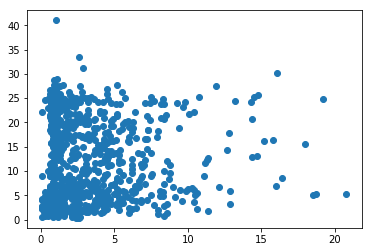

In [12]:
data = data[data['TOUCH_TIME'] > 0].copy() 

def scatter_plot_two_features(data, colnames, total_samples):

    scatter_plot_data = data[[colnames[0], colnames[1]]].sample(n=total_samples)
    x = scatter_plot_data[colnames[0]]
    y = scatter_plot_data[colnames[1]]
    
    plot = plt.scatter(x, y)
    
    return plot


cols = ['TOUCH_TIME', 'SHOT_DIST']
scatter_plot_two_features(data, cols, 1000)

### 4.1 Rescaling

A possible standardization technique is scaling features between a given minimum and maximum value, often between zero and one.

,TOUCH_TIME,SHOT_DIST
33678,0.108871,0.074153
32583,0.024194,0.514831
119865,0.028226,0.169492
60791,0.040323,0.550847
58525,0.020161,0.027542


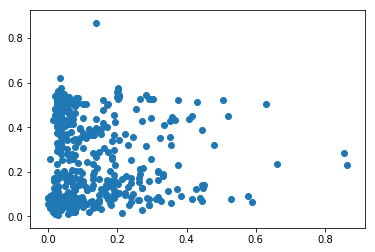

In [13]:
def rescale_columns(data, colnames, total_samples_preview):
    
    scaler = pp.MinMaxScaler()
    
    rescaled_data = data[colnames]
    rescaled_data = scaler.fit_transform(rescaled_data)
    rescaled_data = pd.DataFrame(rescaled_data, columns=colnames)
    
    rescaled_data_sample = rescaled_data.sample(n=5)
    
    scatter_plot_two_features(rescaled_data, colnames, total_samples_preview)
    
    return rescaled_data_sample


rescale_columns(data, cols, 500)

Alternatively, the `MaxAbsScaler()` scaler (used in similar fashion) would return data in the range [-1, 1].

### 4.2 Standardizing

Standardization is a common to make features look more or less look like standard normally distributed data: Gaussian with 0 mean and unit variance.

In practice, we often ignore the shape of the distribution and just transform the data to:

* Center it by removing the mean value of each feature
* Scale it by dividing non-constant features by their standard deviation.

One can assume that, if the data size is huge, both training and validation sets can be approximately viewed as normal distribution.

,TOUCH_TIME,SHOT_DIST
20330,1.187903,-0.344172
40682,-0.717607,1.045974
111816,-0.583887,-1.022292
100000,-0.684177,0.842538
30411,-0.483597,-1.496976


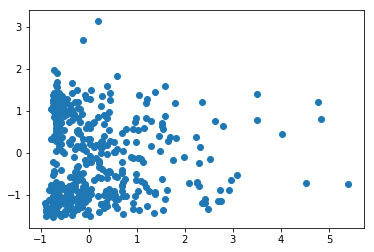

In [14]:
def standardize_columns(data, colnames, total_samples_preview):
    
    scaler = pp.StandardScaler()
    
    rescaled_data = data[colnames]
    rescaled_data = scaler.fit_transform(rescaled_data)
    rescaled_data = pd.DataFrame(rescaled_data, columns=colnames)
    
    rescaled_data_sample = rescaled_data.sample(n=5)
    
    scatter_plot_two_features(rescaled_data, colnames, total_samples_preview)
    
    return rescaled_data_sample


standardize_columns(data, cols, 500)

### 4.3 Normalizing

Normalization is the process of scaling individual samples to have unit norm, i.e. into a vector of length 1.

This process can be useful if you plan to quantify the similarity of any pair of samples, using a dot-product for example.

,TOUCH_TIME,SHOT_DIST
100659,0.031113,0.999516
36113,0.056321,0.998413
102494,0.247833,0.968803
110704,0.263117,0.964764
8433,0.050782,0.998710


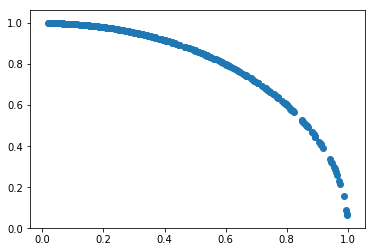

In [15]:
def normalize_columns(data, colnames, total_samples_preview):
    
    scaler = pp.Normalizer()
    
    rescaled_data = data[colnames]
    rescaled_data = scaler.fit_transform(rescaled_data)
    rescaled_data = pd.DataFrame(rescaled_data, columns=colnames)
    
    rescaled_data_sample = rescaled_data.sample(n=5)
    
    scatter_plot_two_features(rescaled_data, colnames, total_samples_preview)
    
    return rescaled_data_sample


normalize_columns(data, cols, 500)

### 4.4 Binarizing

Another strategy we can use is binarization.

Feature binarization is the process of thresholding numerical features to get boolean values.

Here, for example, we can place a threshold in shot distance at 23.9 feet to create a new binary variables: the three point line.

In [16]:
def binarize_columns(data, colnames, threshold):
    
    scaler = pp.Binarizer(threshold=threshold)

    binarized_data = data
    binarized_data['3_POINTER'] = scaler.fit_transform(binarized_data[colnames].values.reshape(-1, 1))
    binarized_data = binarized_data[[colnames, '3_POINTER']]
    binarized_data_sample = binarized_data.sample(n=5)
    
    return binarized_data_sample

three_point_line = 23.9
binarize_columns(data, 'SHOT_DIST', three_point_line)

,SHOT_DIST,3_POINTER
94389,4.3,0.0
86281,23.0,0.0
85835,3.5,0.0
125327,20.8,0.0
7561,12.8,0.0
